In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [17]:
# load the cleaned dataset
data_path = "cleaned_diabetic_data.csv"
df = pd.read_csv(data_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,readmitted,readmitted_binary,admission_type,discharge_disposition,admission_source,diag_1_group,diag_2_group,diag_3_group,med_count,age_numeric
0,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,NO,0,Urgent,Discharged to home,Transfer from hospital,Circulatory,Circulatory,Infectious and parasitic diseases,2,85
1,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,NO,0,Elective,To SNF,Transfer from hospital,Circulatory,Neoplasms,Respiratory,2,95
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,NO,0,Emergency,Discharged to home,Emergency Room,Neoplasms,Neoplasms,Diabetes,2,45
3,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,47,...,>30,0,Emergency,Discharged to home,Emergency Room,Diabetes,Circulatory,Injury,1,45
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,>30,0,Urgent,Discharged to home,Clinic Referral,Circulatory,Circulatory,Diabetes,1,55


In [19]:
med_cols = [ 'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

def create_med_aggregates(df, med_cols):
    # Count how many meds are 'Up' or 'Down' (changed dose)
    df['meds_changed'] = df[med_cols].apply(lambda row: row.isin(['Up', 'Down']).sum(), axis=1)
    return df


# create a fun that create X and Y along with some feature engineer
def create_X_Y_datasets(df):
    df = create_med_aggregates(df, med_cols)

    X = df.drop(columns=med_cols + ['readmitted_binary', 'diag_1', 'diag_2', 'diag_3', 'age', 'encounter_id', 'patient_nbr', 'readmitted', 'num_lab_procedures', 'discharge_disposition', 'admission_source', 'admission_type'])
    y = df['readmitted_binary']

    X_encoded = pd.get_dummies(X, drop_first=True)

    # Split the dataset into training and testing and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

    # apply SMOTE to the training set to handle class imbalance
    smote = SMOTE(random_state=42, sampling_strategy=0.3)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # print out the shape of the datasets
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


    return X_train, X_test, y_train, y_test


# Create the datasets
X_train, X_test, y_train, y_test = create_X_Y_datasets(df)



X_train shape: (58003, 85), y_train shape: (58003,)
X_test shape: (20997, 85), y_test shape: (20997,)


In [20]:
def train_xgboost_model(X_train, y_train, random_seed=42, scale_pos_weight=None):
    xgb_model = xgb.XGBClassifier(
        random_state=random_seed,
        eval_metric="logloss",
        enable_categorical=True,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight
    )

    # Fit the model
    xgb_model.fit(X_train, y_train)
    return xgb_model

# Train the model
xgb_model = train_xgboost_model(X_train, y_train)
# Evaluate the model on the validation set
from sklearn.metrics import accuracy_score, classification_report

y_proba = xgb_model.predict_proba(X_test)[:, 1]
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_test, y_pred))


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     19086
           1       0.22      0.03      0.05      1911

    accuracy                           0.90     20997
   macro avg       0.57      0.51      0.50     20997
weighted avg       0.85      0.90      0.87     20997


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     19086
           1       0.20      0.05      0.08      1911

    accuracy                           0.89     20997
   macro avg       0.55      0.51      0.51     20997
weighted avg       0.85      0.89      0.87     20997


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     19086
           1       0.17      0.09      0.12      1911

    accuracy                           0.88     20997
   macro avg       0.54      0.52      0.53     20997
weighted avg       0.85   

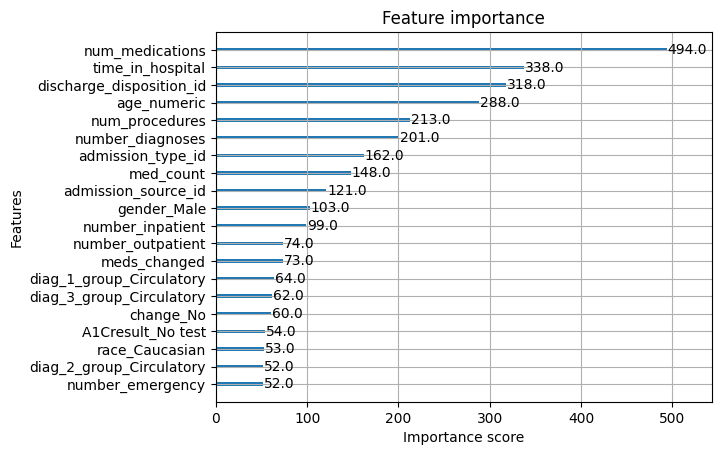

In [7]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()